# A number of tests for a Conversation Agent

An agent answering questions, able to retrieve the provided literature, in a convesation style

In [1]:
import os

from langchain_ollama import OllamaEmbeddings
from langchain_ollama import ChatOllama
from langchain_openai import ChatOpenAI

from langchain_chroma import Chroma
from langchain_community.document_loaders import PyPDFDirectoryLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

from langchain.chains import RetrievalQA

from langchain_core.prompts import PromptTemplate

from dotenv import load_dotenv
from openai import OpenAI

from langchain_core.documents import Document
from re import match

In [2]:
# Settings

lit_directory = "./test_data/" # directory with literature to load for the RAG

db_directory = "./test_chroma_db" # directory to save the vector store

pattern = r"[^\\/]*[\\/](?P<author>.+?) (?P<year>\d{4}) (?P<title>.+)\.pdf" # regex pattern to extract metadata from naming scheme in literature directory. Adjust as needed!

short_docs = True # shorten document from pages to chunks? (set chunk size below)

docs_returned = 6 # number of docs returned by the retriever(s)

retriever_type = "mmr" # "similarity"  or "mmr"

# textgen model. generates answers to questions, with retrieved documents as context
textgen_model = "llama3.2"
# textgen_model = "phi4", # phi4 is a rather powerful model, but requires more gpu compute (that is, it will be slower than llama3.2 if not enough gpu memory is available)

# reasoning model. handles deciding whether or not to query the retriever
reasoning_model = "nemotron-mini" # nvidia's nemotron-mini is smaller, but still capable of the simple reasoning task we need (retrieve or not)
# reasoning_model = "llama3.2" # fast, but not very good at reasoning tasks
# reasoning_model = "qwq" # qwq is a rather powerful experimental reasoning model. However, as it is rather large (20b), it either requires a fair bit of GPU memory or will be very slow 

In [3]:
# set model
# run ollama serve for local API instance
# nomic-embed-text for the embeddings - this model is faster than the llama emebddings and retrieves better results
embeddings = OllamaEmbeddings(model = "nomic-embed-text")

textgen_llm = ChatOllama(
    model = textgen_model,
    temperature = 0.0,
    num_predict = 512, # max number of tokens to generate
    )

# we can use different models for different tasks, e.g. a more expensive model for reasoning (should documents be retrieved?) and a cheaper model for text generation
reasoning_llm = ChatOllama(
    model = reasoning_model, 
    temperature = 0.0,
    num_predict = 512, # max number of tokens to generate
    )

# load_dotenv()
# client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY")) # get API key from .env file

# reasoning_llm = ChatOpenAI(
#     model = "gpt-4o",
#     temperature = 0.0,
#     max_tokens = 512, # max number of tokens to generate
# )


In [4]:
system_prompt = (
  "You are a helpful assistant for finding relevant text passages in scientific literature."
   "Use the following pieces of retrieved context to answer the question."
   "Each piece of content starts with the indicators 'Source' and 'Page'. Always provide these in your answer when using one of the retrieved passages."
   "If you don't know the answer, just say that you don't know, don't try to make up an answer."
)

# note that the generated answer is highly dependent on the system prompt, e.g. adding \n between the lines changes the output
#   (potentially depending on the model)

## Set up  the Vectorstore Retriever

In [5]:
# check if the folder db_directory already exists. If not, creat it and load the documents into the vector store. Else, use the existing vector store. Makes a new DB for shortened docs

if short_docs:
    db_directory += "_short"

if not os.path.exists(db_directory):
    # load documents
    loader = PyPDFDirectoryLoader(lit_directory)
    docs = loader.load() # metadata tracks paper and page number; each page is a single document

    # extract metadata from file names (according to the pattern specified above)
    docs = [
        Document(
            doc.page_content,
            metadata={
                **doc.metadata,
                **({
                    "author_name": metadata.group("author"),
                    "year": metadata.group("year"),
                    "title": metadata.group("title")
                } if (metadata := match(pattern, doc.metadata["source"])) else {})
            }
        )
        for doc in docs
    ]


    # optional step: split the docs into smaller chunks to fit into context window of the model (model dependant, necessary for small models) -!! test this, shorter chunks may lead to bad retrieval results !!-
    #           potential remedy: use whole pages, but use the model to summarise each page before chaining it into the context
    if short_docs:
        text_splitter = RecursiveCharacterTextSplitter(
            chunk_size=1000,  # chunk size (characters)
            chunk_overlap=200,  # chunk overlap (characters)
            add_start_index=True,  # track index in original document
            )
        
        docs = text_splitter.split_documents(docs)

    # make doc vector store. as the vector store can get quite large (and takes time to initialize in memory), we use a chroma database to store the vectors    
    vector_store = Chroma(
        collection_name="lit_helper_test",
        embedding_function=embeddings,
        persist_directory=db_directory,  # save data locally
        )
    
    vector_store.add_documents(docs) # add docs

else:
    vector_store = Chroma(
        collection_name="lit_helper_test",
        embedding_function=embeddings,
        persist_directory=db_directory,  # save data locally
    )


In [6]:
# Set up the retriever

## pass settings (adjust as needed)
if retriever_type == "mmr":
    search_type="mmr" # MMR (Maximal Marginal Relevance) aims to diversify search results. the amount of diversification is set via the lambda_mult parameter
    search_kwargs={"k": docs_returned, # make sure the number of documents passed (k) fits into the context window
                       "fetch_k": docs_returned * 5, # could be adjusted, potentially run tests
                       "lambda_mult": 0.8 # amount of diversification, with 0 being maximum diversity
                       }

if retriever_type == "similarity":
    search_type="similarity" # similarity score; optionally with threshold ("similarity_score_threshold" with "score_threshold" kwarg)
    search_kwargs={"k": docs_returned} # make sure the number of documents passed (k) fits into the context window


retriever = vector_store.as_retriever(
    search_type=search_type, 
    search_kwargs=search_kwargs, 
)

## RAG tool

Note that we're leveraging tool calling and message states in this approach. Among other things, this approach lets the model generate the query by itself (and to skip the retrieval step if the user input does not require it), rather than passing the user question as the retriever query

In [6]:
# retriever as a tool

from langchain_core.tools import StructuredTool

def retrieve(query: str):
    # note that the function name and the doc string of the tool are provided to the model, thus should be descriptive
    """Search and return relevant text passages from scientific literature that can be used to answer the question."""
    retrieved_docs = retriever.invoke(query)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        # (f"Source: {doc.metadata["source"]}\n" f"Page: {doc.metadata["page"]}\n" f"Content: {doc.page_content}") # Alternate format. Does not make the model better at reporting the page, but changes the output
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs
description = "Search and return relevant text passages from scientific literature that can be used to answer the question."
if reasoning_llm.__getattribute__("model") == "nemotron-mini":
    # the additional specifications on the output format are (currently) necessary for the nemotron ollama model, see: https://github.com/ollama/ollama/issues/8287
    description += """
    For each function call, return a json object with function name and arguments within <tool_call></tool_call> XML tags:
    <tool_call>
    {"name": <function-name>, "arguments": <args-json-object>}
    </tool_call>
    """
retriever_tool = StructuredTool.from_function(
    func=retrieve,
    name = "retrieve",
    description = description,
    return_direct=True,
)


In [8]:
from langchain_core.messages import SystemMessage
from langgraph.prebuilt import ToolNode
import json
from langgraph.graph import MessagesState # we're using the MessageState to represent the different parts of our agent in a conversation

# agent to decide whether or not to use tools
def query_or_respond(state: MessagesState):
        """Generate tool call for retrieval or respond directly."""
        llm_with_tools = reasoning_llm.bind_tools([retrieve])
        response = llm_with_tools.invoke(state["messages"])
        # MessagesState appends messages to state instead of overwriting
        return {"messages": [response]}


# build retrieval tool as tool node (receives an AI message from query_or_respond)
tools = ToolNode([retrieve])


# Generate a response
def generate(state: MessagesState):
    """Generate answer."""
    # Get generated ToolMessages
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    # Format into prompt
    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    system_message_content = f"{system_prompt}\n\n{docs_content}"
    
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    # Run
    response = textgen_llm.invoke(prompt)
    return {"messages": [response]}

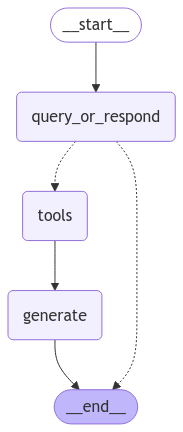

In [10]:
# set up the graph, including a conditional pass on the tools-based generation nodes

from langgraph.graph import END
from langgraph.prebuilt import tools_condition
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState, StateGraph # we're using the MessageState to represent the different parts of our agent in a conversation

tool_graph_builder = StateGraph(MessagesState)

tool_graph_builder.add_node(generate)

tool_graph_builder.add_node(query_or_respond)
tool_graph_builder.set_entry_point("query_or_respond")
tool_graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END: END, "tools": "tools"},
)
tool_graph_builder.add_node(tools)
tool_graph_builder.add_edge("tools", "generate")

tool_graph_builder.add_edge("generate", END)

# add memory for prolongued converstations. For now, saving it in memory is sufficient
memory = MemorySaver()
tool_graph = tool_graph_builder.compile(checkpointer=memory)

# Specify an ID for the thread
config = {"configurable": {"thread_id": "test_thread"}}

display(Image(tool_graph.get_graph().draw_mermaid_png())) # show our graph architecture

In [44]:
input_message = "Hello" # whether or not the model correctly decides to use a tool is highly dependant on the model used; e.g gpt-4o is a lot better at this than llama3.2, qwq and nemotron-mini can handle this too

for step in tool_graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Hello
================================== Ai Message ==================================

 Hello! How can I assist you today?


In [14]:
input_message = "What is the difference between the Public Sphere and the Public Arena?"

for step in tool_graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What is the difference between the Public Sphere and the Public Arena?
================================== Ai Message ==================================
Tool Calls:
  retrieve (1059a823-93d9-4c04-ba58-af5867698ca3)
 Call ID: 1059a823-93d9-4c04-ba58-af5867698ca3
  Args:
    query: difference between the Public Sphere and the Public Arena
================================= Tool Message =================================
Name: retrieve

('Source: {\'author\': \'Jungherr & Schroeder\', \'page\': 8, \'source\': \'test_data\\\\Jungherr & Schroeder 2021 Digital Transformations of the Public Arena.pdf\', \'start_index\': 1665, \'title\': \'Digital Transformations of the Public Arena\', \'year\': \'2021\'}\nContent: (1) The public arena consists of the media infrastructures that enable and\nconstrain the publication, distribution, reception, and contestation of infor-\nmation that allow people to exercise their right

In [15]:
input_message = "According to Jungherr & Schröder, what is the role of contestation in the public arena?"
# there should be a way to implement metadata search in a way that would only retrieve the Jungherr & Schröder text chunks

for step in tool_graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config, # note that this config continues the previous conversation. Depending on the model, it may re-use the previously retrieved documents to answer the question
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

According to Jungherr & Schröder, what is the role of contestation in the public arena?
================================== Ai Message ==================================

 Sorry. I cannot find the answer based on the context provided.


In [16]:
input_message = "According to Nancy Fraser's 1990 paper, what is the role of contestation in the public sphere?"
# there should be a way to implement metadata search in a way that would only retrieve the Jungherr & Schröder text chunks

for step in tool_graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config={"configurable": {"thread_id": "query_test"}}, # new config to test more complex queries
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

According to Nancy Fraser's 1990 paper, what is the role of contestation in the public sphere?
================================== Ai Message ==================================
Tool Calls:
  retrieve (7ac2416b-d2e0-47d1-97cb-399c357d00c1)
 Call ID: 7ac2416b-d2e0-47d1-97cb-399c357d00c1
  Args:
    query: what is the role of contestation in the public sphere?
================================= Tool Message =================================
Name: retrieve

('Source: {\'author\': \'Fraser\', \'page\': 13, \'source\': \'test_data\\\\Fraser 1990 Rethinking the Public Sphere.pdf\', \'start_index\': 817, \'title\': \'Rethinking the Public Sphere\', \'year\': \'1990\'}\nContent: approximated by arrangements that permit contestation among a plurality \nof competing publics than by a single, comprehensive public sphere. Of \ncourse, contestation among competing publics supposes inter-public dis- \ncursive interaction.

Note that in the current implementation, the model is unable to identify documents based on metadata extracted from the user query

## Self Query Retriever with routing agent

In [7]:
# selfquery model, responsible for constructing a structured query from a question
selfquery_model = "phi4" # phi4 seems better at query construction than llama3.2, but requires more gpu compute (i.e. may be slower)

verbose = True # print additional information on routing decisions etc.

selfquery_llm = ChatOllama(
    model = selfquery_model, 
    temperature = 0.0,
    num_predict = 512, # max number of tokens to generate
    )


In [ ]:
# set up the self querying retriever

from langchain.chains.query_constructor.schema import AttributeInfo
from langchain.chains.query_constructor.base import get_query_constructor_prompt
from langchain.chains.query_constructor.base import StructuredQueryOutputParser
from langchain.retrievers.self_query.base import SelfQueryRetriever
from langchain_community.query_constructors.chroma import ChromaTranslator

metadata_field_info = [
    # note that the attribute infos can have a vast influence on the performance of the retriever (likely model dependant)
    #   The name seems to be most important when the model chooses the filter - with notable side effects for other attributes when changing the name of one!
    #   Beware that the names here need to correspond to the names in the metadata of the documents set above (changes in the name here require updating the chroma database)
    AttributeInfo(
        name = "author_name",
        description="The paper author's last name. Abbreviated with et al. for more than two authors.",
        type="string",
    ),
    AttributeInfo(
        name = "year",
        description="The year of publication",
        type="string",
    ),
    AttributeInfo(
        name = "title",
        description="The title of the paper",
        type="string",
    ),
    AttributeInfo(
        name = "page",
        description="The page number of the paper",
        type="string",
    ),
    AttributeInfo(
        name = "source",
        description="The file path of the paper",
        type="string",
    ),
]

document_content_description = "A passage from a scientific paper"


retrieval_prompt = get_query_constructor_prompt( # we're using a premade prompt for the query constructor
    document_contents=document_content_description,
    attribute_info=metadata_field_info,
    # examples = retriever examples, # we can optionally add examples for the model to fine tune the retrieval. See https://github.com/langchain-ai/langchain/blob/master/cookbook/self_query_hotel_search.ipynb
)

output_parser = StructuredQueryOutputParser.from_components( # we're also using a premade output parser
    fix_invalid=True, # this automatically fixes invalid queries (that is, it should avoid errors being thrown when the model constructs an invalid query)
    ) 

query_constructor = retrieval_prompt | selfquery_llm | output_parser # make the query constructor chain

self_query_retriever = SelfQueryRetriever(
    query_constructor=query_constructor,
    vectorstore=vector_store,
    structured_query_translator=ChromaTranslator(), # we need to specify the translator for our database scheme, e.g. Chroma
    search_type=search_type,
    search_kwargs=search_kwargs, 
)

print(retrieval_prompt.format(query="{query}")) # print out the prompt used for the query constructor



Your goal is to structure the user's query to match the request schema provided below.

<< Structured Request Schema >>
When responding use a markdown code snippet with a JSON object formatted in the following schema:

```json
{
    "query": string \ text string to compare to document contents
    "filter": string \ logical condition statement for filtering documents
}
```

The query string should contain only text that is expected to match the contents of documents. Any conditions in the filter should not be mentioned in the query as well.

A logical condition statement is composed of one or more comparison and logical operation statements.

A comparison statement takes the form: `comp(attr, val)`:
- `comp` (eq | ne | gt | gte | lt | lte | contain | like | in | nin): comparator
- `attr` (string):  name of attribute to apply the comparison to
- `val` (string): is the comparison value

A logical operation statement takes the form `op(statement1, statement2, ...)`:
- `op` (and | or | not

In [9]:
# rather than using a MessagesState, we use a GraphState with a custom schema here

from typing_extensions import TypedDict
from typing import List

class GraphState(TypedDict):
    """
    Graph state is a dictionary that contains information we want to propagate to, and modify in, each graph node.
    """

    question: str  # User question
    generation: str  # LLM generation
    decision: str  # router decision
    retrieved_docs: List[str]  # List of retrieved documents
    serialized: str  # Serialized retrieved documents

In [10]:
# build the router

from langchain_core.messages import SystemMessage, HumanMessage
import json


# router instructions. behavior of the router is highly sensitive to the prompt!
router_instructions = """
You are an expert at deciding whether or not to query a search on a vectorstore or respondend to the user directly.
The vectorstore contains passages from scientific articles. Assume that questions are most likely about the content of these articles. Only respond directly to generic user input, such as greetings. Else query a retrieval.
Return JSON with single key, datasource, that is 'retrieve' or 'respond' depending on the question."""

# turn the reasoning model into a json model for more structured output (more robust than text output)
reasoning_llm_json = ChatOllama(model=reasoning_model, 
                            temperature=0, 
                            format="json")

def route_question(state):
    """
    Route question to retriever or respond directly.
    Args:
        state (dict): The current graph state
    Returns:
        str: Next node to call
    """
    # format messages & make prompt
    
    prompt = [SystemMessage(router_instructions)] + [HumanMessage(state["question"])]
    if verbose: print("---ROUTE QUESTION---")
    route_question = reasoning_llm_json.invoke(prompt)
    source = json.loads(route_question.content)["datasource"]
    if source == "retrieve":
        if verbose: print("---ROUTE QUESTION TO RETRIEVER---")
        decision = "query_retrieve"
    elif source == "respond":
        if verbose: print("---RESPOND DIRECTLY---")
        decision = "respond"
    return decision


In [11]:
# build the retriever 

def sq_retrieve(state):
    """
    Retrieve documents from vectorstore
    Args:
        state (dict): The current graph state
    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    if verbose: print("---RETRIEVE---") 
    retrieved_docs = self_query_retriever.invoke(state["question"])
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        # (f"Source: {doc.metadata["source"]}\n" f"Page: {doc.metadata["page"]}\n" f"Content: {doc.page_content}") # Alternate format. Does not make the model better at reporting the page, but changes the output
        for doc in retrieved_docs
    )
    return {"serialized": serialized, 
            "retrieved_docs": retrieved_docs}

In [12]:
# Generate a response
def sq_generate(state):
    """
    Generate answer using RAG on retrieved documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    if verbose: print("---GENERATE---")
    # documents = state["retrieved_docs"]
    if "serialized" in state:
        docs_content = state["serialized"] # retrieved documents in serialized form
        system_message_content = f"{system_prompt}\n\n{docs_content}" # add retrieved docs to system message
    else:
        system_message_content = f"{system_prompt}\n"
    # RAG generation
    
    prompt = [SystemMessage(system_message_content)] + [HumanMessage(state["question"])]
    generation = textgen_llm.invoke(prompt)
    return {"generation": generation}

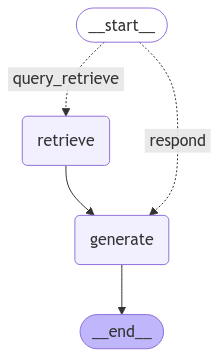

In [13]:
from langgraph.graph import END
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph # we're using the custom graph scheme above

sq_graph_builder = StateGraph(GraphState)

sq_graph_builder.add_node("generate", sq_generate)

sq_graph_builder.set_conditional_entry_point(
    route_question,
    {
        "query_retrieve": "retrieve",
        "respond": "generate",
    }
)

sq_graph_builder.add_node("retrieve", sq_retrieve)

sq_graph_builder.add_edge("retrieve", "generate")

sq_graph_builder.add_edge("generate", END)

# add memory for prolongued converstations. For now, saving it in memory is sufficient
memory = MemorySaver()
sq_graph = sq_graph_builder.compile(checkpointer=memory)

# Specify an ID for the thread
config = {"configurable": {"thread_id": "test_thread_sq"}}

display(Image(sq_graph.get_graph().draw_mermaid_png())) # show our graph architecture


In [53]:
input_message = "Hello" # whether or not the model correctly decides to use a tool is highly dependant on the model used; e.g gpt-4o is a lot better at this than llama3.2, qwq and nemotron-mini can handle this too

for step in sq_graph.stream(
    {"question": input_message},
    stream_mode="values",
    config=config,
):
    print(step)

---ROUTE QUESTION---
---RESPOND DIRECTLY---
{'question': 'Hello', 'generation': AIMessage(content='I don\'t know the answer to this question based on the provided passages. The terms "Public Sphere" and "Public Arena" are mentioned in the texts, but their meanings and relationships are not explicitly defined or compared.\n\nHowever, I can suggest that the authors of the passages seem to be using these terms somewhat interchangeably, with some nuances. For example, Fraser (1990) discusses the concept of a "public sphere," which refers to a space where citizens can engage in public discourse and participate in decision-making processes. In contrast, Jungherr & Schroeder (2021) discuss the concept of a "Public Arena," which seems to refer to the media infrastructures that enable and constrain the publication, distribution, reception, and contestation of information.\n\nIt\'s possible that the authors are using these terms to describe different aspects of public discourse or civic engageme

In [49]:
input_message = "What is the difference between the Public Sphere and the Public Arena?"

for step in sq_graph.stream(
    {"question": input_message},
    stream_mode="values",
    config=config,
):
    print(step)

---ROUTE QUESTION---
---ROUTE QUESTION TO RETRIEVER---
{'question': 'What is the difference between the Public Sphere and the Public Arena?'}
---RETRIEVE---
{'question': 'What is the difference between the Public Sphere and the Public Arena?', 'retrieved_docs': [Document(metadata={'author': 'Jungherr & Schroeder', 'page': 8, 'source': 'test_data\\Jungherr & Schroeder 2021 Digital Transformations of the Public Arena.pdf', 'start_index': 1665, 'title': 'Digital Transformations of the Public Arena', 'year': '2021'}, page_content='(1) The public arena consists of the media infrastructures that enable and\nconstrain the publication, distribution, reception, and contestation of infor-\nmation that allow people to exercise their rights and duties as citizens.\n(2) This excludes how people use these infrastructures for private life or for\ncommercial purposes except when these uses come to bear on people’s\nrights and duties as citizens.\n(3) These infrastructures mediate the relation between 

In [15]:
input_message = "According to Nancy Fraser's 1990 paper, what is the role of contestation in the public sphere?"
# there should be a way to implement metadata search in a way that would only retrieve the Jungherr & Schröder text chunks

for step in sq_graph.stream(
    {"question": input_message},
    stream_mode="values",
    config={"configurable": {"thread_id": "query_test"}}, # new config to test more complex queries
):
    print(step)

---ROUTE QUESTION---
---ROUTE QUESTION TO RETRIEVER---
{'question': "According to Nancy Fraser's 1990 paper, what is the role of contestation in the public sphere?"}
---RETRIEVE---
{'question': "According to Nancy Fraser's 1990 paper, what is the role of contestation in the public sphere?", 'retrieved_docs': [Document(metadata={'author_name': 'Fraser', 'page': 13, 'source': 'test_data\\Fraser 1990 Rethinking the Public Sphere.pdf', 'start_index': 817, 'title': 'Rethinking the Public Sphere', 'year': '1990'}, page_content='approximated by arrangements that permit contestation among a plurality \nof competing publics than by a single, comprehensive public sphere. Of \ncourse, contestation among competing publics supposes inter-public dis- \ncursive interaction. How, then, should we understand such interaction? \nGeoff Eley suggests we think of the public sphere [in stratified societies] \nas "the structured setting where cultural and ideological contest or nego- \ntiation among a variety

## React Agent

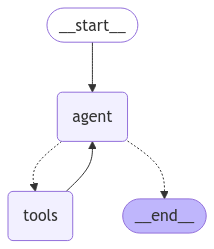

In [14]:
# let's see if a react agent fares better in deciding when to use the tool
#   note that this does not give us the option of choosing different models for different steps in the graph
#   also ensure that the model is able to implement tools - e.g. phi4 is unable to do so

from langgraph.prebuilt import create_react_agent

agent_executor = create_react_agent(reasoning_llm, [retrieve], 
                                    state_modifier=system_prompt,
                                    checkpointer=memory)

display(Image(agent_executor.get_graph().draw_mermaid_png()))

In [15]:
config = {"configurable": {"thread_id": "test_2"}}

input_message = (
    "Hello"  # llama 3.2 still calls the retrieval tool here, even when using an agent. Models with better reasoning capabilities (qwq, gpt-4o, nemotron-mini) do not
)

for event in agent_executor.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hello
================================== Ai Message ==================================

 Hello! I'm here to help you find relevant text passages from scientific literature. Please provide me with your question or query, and I will do my best to assist you.


In [16]:
config = {"configurable": {"thread_id": "test_3"}}

input_message = "According to Jungherr & Schröder, what is the role of contestation in the public arena?"


for event in agent_executor.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

According to Jungherr & Schröder, what is the role of contestation in the public arena?
================================== Ai Message ==================================
Tool Calls:
  retrieve (c91a7698-e9d1-4c2f-ae42-a57a3e9f08b1)
 Call ID: c91a7698-e9d1-4c2f-ae42-a57a3e9f08b1
  Args:
    query: What is the role of contestation in the public arena according to Jungherr & Schröder?
================================= Tool Message =================================
Name: retrieve

Source: {'page': 62, 'source': 'test_data\\Jungherr & Schroeder 2021 Digital Transformations of the Public Arena.pdf', 'start_index': 0}
Content: Beyond these general observations, there are speciﬁc take-aways from our
cases regarding two themes: how the public arena provides space for challenges
to the status quo and the role of the public arena as staging ground for societal
conﬂict.
Challenges to the Status Quo
In China, the expan

Interestingly, the output between the agent and the above chain differs considerably, even though the retrieved content and system message are identical. The agent seems to do a better job at answering the question here (model-dependant).

In [21]:
config = {"configurable": {"thread_id": "test_3"}} # using the same thread as the previous question to continure the conversation

input_message = "What is the difference between Fraser's critique of the public sphere and Jungherr & Schröder's concept of the public arena?"


for event in agent_executor.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is the difference between Fraser's critique of the public sphere and Jungherr & Schröder's concept of the public arena?
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_7ma6ltdEmjyZnARToxp6PcKX)
 Call ID: call_7ma6ltdEmjyZnARToxp6PcKX
  Args:
    query: Fraser's critique of the public sphere
  retrieve (call_i3ZA6cyaytIUOIQIFw9gm53G)
 Call ID: call_i3ZA6cyaytIUOIQIFw9gm53G
  Args:
    query: Jungherr & Schröder's concept of the public arena
================================= Tool Message =================================
Name: retrieve

Source: {'page': 62, 'source': 'test_data\\Jungherr & Schroeder 2021 Digital Transformations of the Public Arena.pdf', 'start_index': 0}
Content: Beyond these general observations, there are speciﬁc take-aways from our
cases regarding two themes: how the public arena provides space for challenges
to the statu

Most agents do not split the retrieval call into 2 different calls, even though it would be appropriate here. However, gpt-4o does, and generates a satisfactory answer when paired with a nomic retriever. However, it is unclear how gpt-4o knows to refer to the Fraser sources mentioned in its answer, as they were not part of the retriever results. Potentially a trace from previous API calls stored in the memory on the open AI server side? Or does the tool call not print out the first query here?

*to do:*
- integrate self-query retriever as tool for the react agent for testing purposes
- implement Wikipedia API as retriever tool and modify decision agent
- implement Zotero API integration for literature search